In [160]:
import numpy as np
from itertools import combinations
from scipy.stats import binom
import scipy.special
import matplotlib.pyplot as plt
from scipy.stats import ortho_group

In [11]:
def get_index_lists_I_and_J(E,n,N,d):
    I_n = list(range(d))
    J_n = list(range(d))
    n_ = n+1
    for m in reversed(range(d)):
        if E[m,n_-1] in E[J_n,n_]:
            del I_n[m]
            t_J_n = [i for i in J_n if E[i,n_] == E[m,n_-1] ]
            m_max = max(t_J_n)
            del J_n[m_max]
    return I_n,J_n

In [12]:
def diff_of_lists(first, second):
        second = set(second)
        return [item for item in first if item not in second]

In [13]:
def get_permutation_I(I_n,d):
    permutation = [0]*d
    r_n = np.shape(I_n)[0]
    complementary_I_n = diff_of_lists(list(range(d)),I_n)
    c_r_n = d-r_n
    for i in range(r_n):
        permutation[I_n[i]] = i
    for i in range(c_r_n):
        permutation[complementary_I_n[i]] = i + r_n
    return permutation

In [15]:
def get_v_n_w_n(E,I_n,J_n,d,n):
    r_n = np.shape(I_n)[0]
    v_n = np.zeros((r_n))
    w_n = np.zeros((r_n))
    permutation_I_n = get_permutation_I(I_n,d)
    permutation_J_n = get_permutation_I(J_n,d)
    for m in I_n:
        v_n_index = permutation_I_n[m]
        nom_v_n = E[m,n]*np.ones((r_n,1)) - E[list(J_n),n+1]
        I_n_without_m = diff_of_lists(I_n,[m])
        cardinal_I_n_without_m = np.shape(I_n_without_m)[0]
        denom_v_n = E[m,n]*np.ones((cardinal_I_n_without_m,1)) - E[list(I_n_without_m),n]
        v_n[v_n_index] = np.sqrt(-np.prod(nom_v_n)/np.prod(denom_v_n))
    for m in J_n:
        w_n_index = permutation_J_n[m]
        nom_w_n = E[m,n+1]*np.ones((r_n,1)) - E[list(I_n),n]
        J_n_without_m = diff_of_lists(J_n,[m])
        cardinal_J_n_without_m = np.shape(J_n_without_m)[0]
        denom_w_n = E[m,n+1]*np.ones((cardinal_J_n_without_m,1)) - E[list(J_n_without_m),n+1]
        w_n[w_n_index] = np.sqrt(np.prod(nom_w_n)/np.prod(denom_w_n))
        
    return v_n,w_n

In [16]:
def get_permutation_matrix(permutation,d):
    permutation_matrix = np.zeros((d,d))
    for i in range(d):
        for j in range(d):
            if i == permutation[j]:
                permutation_matrix[i,j] = 1
    return permutation_matrix

In [17]:
def get_W_n_matrix(E,I_n,J_n,d,n):
    r_n = np.shape(I_n)[0]
    v_n,w_n = get_v_n_w_n(E,I_n,J_n,d,n)
    W_n_matrix = np.zeros((r_n,r_n))
    permutation_I_n = get_permutation_I(I_n,d)
    permutation_J_n = get_permutation_I(J_n,d)
    for m in I_n:
        for m_ in J_n:
            v_n_index = permutation_I_n[m]
            w_n_index = permutation_J_n[m_]
            W_n_matrix[v_n_index,w_n_index] = 1/(E[m_,n+1]-E[m,n])*v_n[v_n_index]*w_n[w_n_index]
    return W_n_matrix

In [18]:
def get_padded_vector(v,d):
    r_n = np.shape(v)[0]
    v_padded = np.zeros((d,))
    v_padded[0:r_n] = v
    return v_padded

In [19]:
def get_extended_matrix_W(W_n_matrix,d):
    r_n = np.shape(W_n_matrix)[0]
    W_extended = np.eye(d)
    W_extended[0:r_n,0:r_n] = W_n_matrix
    return W_extended

In [332]:
def get_F(d,N,E,mu_vector):
    F_test = np.zeros((d,N))
    U_n_1 = np.eye(d)
    for n in range(N):
        #print(n)
        if n ==0:
            M = np.eye(d)
            F_test[:,n],U_n_1 = get_F_n_U_n(n+1,d,N,E,mu_vector,M)
        else:
            F_test[:,n],U_n_1 = get_F_n_U_n(n+1,d,N,E,mu_vector,U_n_1)
    return F_test

In [323]:
def generate_random_diagonal_unimodular_matrix(d):
    vector = np.ones((1,d)) - 2*np.random.binomial(1, 0.5, d)
    return np.diag(vector[0])
    #return np.eye(d)

In [336]:
def get_F_n_U_n(n,d,N,E,mu_vector,U_n_1):
    #print(n)
    if n==1:
        M = np.eye(d)
        v = np.sqrt(mu_vector[0])*M[:,0]
        return v,np.eye(d)
    I_n,J_n = get_index_lists_I_and_J(E,n-1,N,d)
    r_n = np.shape(I_n)[0]
    permutation_matrix_I_n = get_permutation_matrix(get_permutation_I(I_n,d),d)
    permutation_matrix_J_n = get_permutation_matrix(get_permutation_I(J_n,d),d)
    v_n,w_n = get_v_n_w_n(E,I_n,J_n,d,n-1)
    W_extended = get_extended_matrix_W(get_W_n_matrix(E,I_n,J_n,d,n-1),d)
    v_padded = get_padded_vector(v_n,d)
    V_n = generate_random_diagonal_unimodular_matrix(d)
    U_n = np.dot(np.dot(np.dot(np.dot(U_n_1,V_n),np.transpose(permutation_matrix_I_n)),W_extended),permutation_matrix_J_n)
    f_n = np.dot(np.dot(np.dot(U_n_1,V_n),np.transpose(permutation_matrix_I_n)),v_padded)
    return f_n,U_n

## Create an eigensteps

In [89]:
for n in range(N-2,-1,-1):#iter([N-2,N-3,N-4,N-5,N-6]):
    #print(n)
    if n > -1:
        #print(list(range(n, 0, -1)))
        for k in range(n, -1, -1):
            #print("k is")
            #print(k)
            #n -> N-2
            #n+1 -> N-1
            #k_aux = k+1
            #print(n)
            A_n_1_k = max(E[k+1,n+1],np.sum(E[k:n+2,n+1])-np.sum(E[k+1:n+1,n])-mu_vector[n+1])
            B_array = np.zeros(k+1)
            for l in range(k+1):
                B_array[l] = np.sum(mu_vector[l:n+1])-np.sum(E[l+1:k+1,n+1])-np.sum(E[k+1:n+1,n])
                #print(l)
            #print(B_array)
            B_n_1_k = min(E[k,n+1],min(B_array))
            #print("n is:")
            #print(n)
            #print("k is:")
            #print(k)
            #print("E[k,n+1] is")
            #print(E[k,n+1])
            #print("B_n_1_k is:")
            #print(B_n_1_k)
            
            E[k,n] = (A_n_1_k+B_n_1_k)/2
            #print(A_n_1_k)
            #print(B_n_1_k)

In [90]:

E_column_sum = np.zeros((N))
for n in range(N):
    E_column_sum[n] = np.sum(E[:,n])

In [91]:
E_column_sum

array([ 0.6,  1.2,  1.8,  2.4,  3. ])

In [92]:
E

array([[ 0.6,  0.8,  1. ,  1. ,  1. ],
       [ 0. ,  0.4,  0.6,  1. ,  1. ],
       [ 0. ,  0. ,  0.2,  0.4,  1. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ],
       [ 0. ,  0. ,  0. ,  0. ,  0. ]])

In [93]:
def get_eigensteps_random(mu_vector,lambda_vector,N,d):
    E = np.zeros((N,N)) #(d,N)
    E[:,N-1] = lambda_vector
    for n in range(N-2,-1,-1):
        #print(n)
        for k in range(n, -1, -1):
            A_n_1_k = max(E[k+1,n+1],np.sum(E[k:n+2,n+1])-np.sum(E[k+1:n+1,n])-mu_vector[n+1])
            B_array = np.zeros(k+1)
            for l in range(k+1):
                B_array[l] = np.sum(mu_vector[l:n+1])-np.sum(E[l+1:k+1,n+1])-np.sum(E[k+1:n+1,n])
            B_n_1_k = min(E[k,n+1],min(B_array))
            u = np.random.uniform(0,1)
            delta_n_1_k = B_n_1_k - A_n_1_k
            E[k,n] = A_n_1_k + u*delta_n_1_k
    return E

In [94]:
def get_eigensteps_mean(mu_vector,lambda_vector,N,d):
    E = np.zeros((N,N)) #(d,N)
    E[:,N-1] = lambda_vector
    for n in range(N-2,-1,-1):
        #print(n)
        for k in range(n, -1, -1):
            A_n_1_k = max(E[k+1,n+1],np.sum(E[k:n+2,n+1])-np.sum(E[k+1:n+1,n])-mu_vector[n+1])
            B_array = np.zeros(k+1)
            for l in range(k+1):
                B_array[l] = np.sum(mu_vector[l:n+1])-np.sum(E[l+1:k+1,n+1])-np.sum(E[k+1:n,n])
            B_n_1_k = min(E[k,n+1],min(B_array))
            u = np.random.uniform(0,1)
            E[k,n] = A_n_1_k
    return E

In [407]:
N= 50
d = 2
E = np.zeros((N,N)) #(d,N)
mu_vector = d/N*np.ones((N,1))
lambda_vector = np.zeros((N))
lambda_vector[0:d] = np.ones((d))

In [408]:
mu_vector = np.linspace(1, 0.1, num=N)
sum_mu_vector = np.sum(mu_vector)
mu_vector = d/sum_mu_vector*mu_vector

mu_vector = d/N*np.ones((N,1))

In [436]:

E_test = get_eigensteps_random(mu_vector,lambda_vector,N,d)
E_ = np.zeros((d,N+1))
for i in range(d):
    E_[i,1:N+1] = E_test[i,:] 
F_test = get_F(d,N,np.asmatrix(E_),mu_vector)


In [437]:
E_column_sum = np.zeros((N,1))
for n in range(N):
    E_column_sum[n] = np.sum(E_test[:,n])


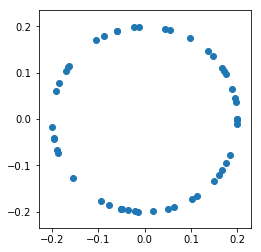

In [438]:
plt.scatter(F_test[0,0:N], F_test[1,0:N])
plt.gca().set_aspect('equal')
plt.show()

In [393]:
np.dot(F_test[:,0:N],F_test[:,0:N].T)

array([[  1.00000000e+00,  -7.89299182e-17],
       [ -7.89299182e-17,   1.00000000e+00]])

In [394]:
np.diag(np.dot(F_test[:,0:N].T,F_test[:,0:N]))

array([ 0.07272727,  0.07139147,  0.07005566,  0.06871985,  0.06738404,
        0.06604824,  0.06471243,  0.06337662,  0.06204082,  0.06070501,
        0.0593692 ,  0.0580334 ,  0.05669759,  0.05536178,  0.05402597,
        0.05269017,  0.05135436,  0.05001855,  0.04868275,  0.04734694,
        0.04601113,  0.04467532,  0.04333952,  0.04200371,  0.0406679 ,
        0.0393321 ,  0.03799629,  0.03666048,  0.03532468,  0.03398887,
        0.03265306,  0.03131725,  0.02998145,  0.02864564,  0.02730983,
        0.02597403,  0.02463822,  0.02330241,  0.0219666 ,  0.0206308 ,
        0.01929499,  0.01795918,  0.01662338,  0.01528757,  0.01395176,
        0.01261596,  0.01128015,  0.00994434,  0.00860853,  0.00727273])

In [384]:
mu_vector

array([ 0.07272727,  0.07139147,  0.07005566,  0.06871985,  0.06738404,
        0.06604824,  0.06471243,  0.06337662,  0.06204082,  0.06070501,
        0.0593692 ,  0.0580334 ,  0.05669759,  0.05536178,  0.05402597,
        0.05269017,  0.05135436,  0.05001855,  0.04868275,  0.04734694,
        0.04601113,  0.04467532,  0.04333952,  0.04200371,  0.0406679 ,
        0.0393321 ,  0.03799629,  0.03666048,  0.03532468,  0.03398887,
        0.03265306,  0.03131725,  0.02998145,  0.02864564,  0.02730983,
        0.02597403,  0.02463822,  0.02330241,  0.0219666 ,  0.0206308 ,
        0.01929499,  0.01795918,  0.01662338,  0.01528757,  0.01395176,
        0.01261596,  0.01128015,  0.00994434,  0.00860853,  0.00727273])

In [162]:
x

array([[-0.47128663,  0.09340299, -0.8770204 ],
       [ 0.67864901, -0.59669884, -0.42823595],
       [-0.56331557, -0.7970109 ,  0.21782834]])

In [161]:
x = ortho_group.rvs(3)

In [164]:
def list_duplicates(seq):
    seen = set()
    seen_add = seen.add
    return [idx for idx,item in enumerate(seq) if item in seen or seen_add(item)]

print(list_duplicates([1, 2, 3, 2, 1, 5, 6, 5, 5, 5]))
# [3, 4, 7, 8, 9]

[3, 4, 7, 8, 9]
